This is the second part of the clustering example and it shall guide you through visualisations of clusters in real life and how to inspect them.  

1. Load packages and Data
2. Return to simple way of visualising customers. Folium MAPS.
3. Statistical approach to values of neighborhood

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import folium as folium
from folium.plugins import HeatMap,HeatMapWithTime
import pgeocode
# set country to seek for US postal codes
nomi = pgeocode.Nominatim('US') 
# Change settings to display all columns
pd.options.display.max_columns = None

# Create color map
cm = sns.light_palette("green", as_cmap=True)

## Load Data

In [2]:
# Load data
labeled = pd.read_csv("neighborhood.csv", low_memory=False)

In [3]:
labeled.drop("Unnamed: 0", axis=1, inplace = True)
labeled.head(5)

,STATE,ZIP,HOMEOWNR,INCOME,HIT,male,female,couple,age,ses,AGE904,IC3,HHAS3,AFC4,EC3,LFC4,LFC5,label_1,City,Rural,Suburban,Town,Urban,label_2
0,NC,27892,0.0,0.666667,0.0000,0.0,1.0,0.0,0.573770,0.333333,0.473684,0.198322,0.272727,0.111111,0.403846,0.717172,0.505051,1,0,1,0,0,0,1
1,FL,32579,1.0,0.833333,0.0000,0.0,1.0,0.0,0.377049,0.000000,0.407895,0.290618,0.505051,0.191919,0.153846,0.696970,0.585859,2,1,0,0,0,0,1
2,OR,97103,1.0,0.166667,0.0125,0.0,1.0,0.0,0.983607,0.333333,0.473684,0.245614,0.434343,0.202020,0.211538,0.696970,0.515152,1,0,0,0,1,0,1
3,TX,79015,1.0,1.000000,0.0125,0.0,1.0,0.0,0.295082,0.333333,0.434211,0.218154,0.333333,0.080808,0.134615,0.636364,0.494949,1,1,0,0,0,0,1
4,MI,49287,1.0,0.500000,0.1250,1.0,0.0,0.0,0.622951,0.333333,0.460526,0.327231,0.525253,0.151515,0.288462,0.707071,0.505051,2,0,1,0,0,0,0


In [4]:
labeled.columns

Index(['STATE', 'ZIP', 'HOMEOWNR', 'INCOME', 'HIT', 'male', 'female', 'couple',
       'age', 'ses', 'AGE904', 'IC3', 'HHAS3', 'AFC4', 'EC3', 'LFC4', 'LFC5',
       'label_1', 'City', 'Rural', 'Suburban', 'Town', 'Urban', 'label_2'],
      dtype='object')

## Folium maps

### Visualising clusters on the map  
As we now have the labels from unsupervised ML notebook, I will present several different map styles and show how you can pin a point on it  
For the purpose of map visualisations folium maps seems to be a very convenient solution  


#### First - Get positional data using ZIP code


In [5]:
# get coordinates
# will Retrieve latitude and longitude from zip code using pgeocode"
       
lat = []
lon = []
for i in range(len(labeled['ZIP'])):
    lat.append(nomi.query_postal_code(str(labeled.loc[i]['ZIP'])).latitude)
    lon.append(nomi.query_postal_code(str(labeled.loc[i]['ZIP'])).longitude)

labeled['latitude'] = lat
labeled['longitude'] = lon

# third mask the NAN values
labeled['latitude'].fillna(90,inplace=True)             #mask na as to be living in the north pole
labeled['longitude'].fillna(0,inplace=True) 

In [6]:
# markers are computationally expensive, therefore i will only use 300 people from each cluster
c1 = labeled[labeled['label_1'] == 0][:300]
c2 = labeled[labeled['label_1'] == 1][:300]
c3 = labeled[labeled['label_1'] == 2][:300]

concat = pd.concat([c1, c2, c3], axis = 0)

In [7]:
### use of markers - it is computationally expensive, but you can
### have more information accessible by hoovering on marker

In [8]:
# create df for markers
heater_df = concat.sort_values('label_1',ascending=True)
marker_data = []
for _, d in heater_df.groupby(['label_1']):
    marker_data.append([[row['latitude'], row['longitude']] for _, row in d.iterrows()])

In [9]:
marks = folium.Map(location=[38, -102], tiles="Stamen Toner", zoom_start=4)

#how to call your groups?
tooltip1 = "Average"
tooltip2 = "Lower"
tooltip3 = "Upper"

for i in range(len(marker_data[0])):
    folium.Marker(marker_data[0][i], tooltip=tooltip1, icon=folium.Icon(color="green")).add_to(marks)
    
for i in range(len(marker_data[1])):
    folium.Marker(marker_data[1][i], tooltip=tooltip2, icon=folium.Icon(color="red")).add_to(marks)
    
for i in range(len(marker_data[2])):
    folium.Marker(marker_data[2][i], tooltip=tooltip3, icon=folium.Icon(color="blue")).add_to(marks)

marks

In [10]:
# instead of pins we can use circles, that would look nicer and goes easier on the memory

In [11]:
markson = folium.Map(location=[38, -102], tiles="Stamen Toner", zoom_start=4)
for i in range(len(marker_data[0])):
    folium.Circle(radius=50,location=marker_data[0][i], popup=tooltip1,
        color="crimson",fill=False,).add_to(markson)
for i in range(len(marker_data[1])):
    folium.Circle(radius=50,location=marker_data[1][i], popup=tooltip2,
        color="blue",fill=False,).add_to(markson)
for i in range(len(marker_data[2])):
    folium.Circle(radius=50,location=marker_data[2][i], popup=tooltip3,
        color="green",fill=False,).add_to(markson)
    
markson

In [12]:
# we can see that blue dots and green dots are scattered all around the country whereas red dots seem to be concentrated in south east. 
# from what previously was a data point, now you can see the actual location of it

###  Use of heatmaps
#### First partition map

In [13]:
# This is a way around a problem. Heatmaps should be used with timed data, but we can convert cluster labels to act as time stamps.
# Will create a maps to represent each cluster combination seperately.

## Label - 1 Neighborhood 
## initialize the map
first_partition_map = folium.Map(location=[38, -102],zoom_start = 4) 

## Ensure it's floats
labeled['latitude'] = labeled['latitude'].astype(float)
labeled['longitude'] = labeled['longitude'].astype(float)

# create time series based on label values

heat0_df = labeled.sort_values('label_1',ascending=True)
tdata = []
for _, d in heat0_df.groupby(['label_1']):
    tdata.append([[row['latitude'], row['longitude'], row['label_1']] for _, row in d.iterrows()])
# load a plugin
hm = HeatMapWithTime(tdata, auto_play=True,max_opacity=0.2)
hm.add_to(first_partition_map)

# Display the map
first_partition_map

#### Second partition map

In [14]:
# shall create a map to represent each cluster after second cluster labels (General)

#initialize
second_partition_map = folium.Map(location=[38, -102],zoom_start = 4)  

# create time series based on label values

heat0_df = labeled.sort_values('label_2',ascending=True)
tdata = []
for _, d in heat0_df.groupby(['label_2']):
    tdata.append([[row['latitude'], row['longitude'], row['label_2']] for _, row in d.iterrows()])
# load a plugin
hm = HeatMapWithTime(tdata, auto_play=True,max_opacity=0.2)
hm.add_to(second_partition_map)

# export
#second_partition_map.save("second_partition_map.html")

# Display the map
second_partition_map

#### Final map based on hierarchical clustering combinations

In [15]:
# cheking the results after creating the histogram
# shall create a map to represent each cluster combination seperately (3x3)

#initialize
cluster_map = folium.Map(location=[38, -102],zoom_start = 4) 

# create time series based on label values

heat0_df = labeled.sort_values('label_1',ascending=True)
tdata = []
for _, d in heat0_df.groupby(['label_1','label_2']):
    tdata.append([[row['latitude'], row['longitude'], row['label_2']] for _, row in d.iterrows()])
# load a plugin
hm = HeatMapWithTime(tdata, auto_play=True,max_opacity=0.2)
hm.add_to(cluster_map)

# export
#cluster_map.save("Final_cluster_map.html")

# Display the map
cluster_map

In [16]:
# Let's dive deeper into neightbood data and inspect if there are any significant differences amongst clusters
# according to PCA and TSNE there should be distinct differences towards education and average HH income

## General Statistics

#### Will inspect the neghborhood data in terms of:  


- Number of Persons 
- Median Age of Adults   
- Percent Households w/ Person 65+  
- Average Home Value in hundreds 
- Income  
- Percent Adults in Active Military Service  

# Neighborhood police
' aka some statistics to work with

In [17]:
def statistics(variable):
    if variable.dtypes == "int64" or variable.dtype == "float64":
        return pd.DataFrame([[variable.name, np.mean(variable), np.std(variable), np.median(variable), np.var(variable)]], 
                            columns = ["Variable", "Mean", "Standard Deviation", "Median", "Variance"]).set_index("Variable")
    else:
        return pd.DataFrame(variable.value_counts())
def graph_histo(x):
    if x.dtype == "int64" or x.dtype == "float64":
        # Select size of bins by getting maximum and minimum and divide the substraction by 10
        size_bins = 10
        # Get the title by getting the name of the column
        title = "Distribution plot"
        #Assign random colors to each graph
        color_kde = list(map(float, np.random.rand(3,)))
        color_bar = list(map(float, np.random.rand(3,)))

        # Plot the displot
        sns.distplot(x, bins=size_bins, kde_kws={"lw": 1.5, "alpha":0.8, "color":color_kde},
                       hist_kws={"linewidth": 1.5, "edgecolor": "grey",
                                "alpha": 0.4, "color":color_bar})
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.ylabel("Frequency", size=16, labelpad=15);
        # Customize title
        plt.title(title, size=18)
        # Customize grid and axes visibility
        plt.grid(False);
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);   
    else:
        x = pd.DataFrame(x)
        # Plot       
        sns.catplot(x=x.columns[0], kind="count", palette="spring", data=x)
        # Customize title
        title = x.columns[0]
        plt.title(title, size=18)
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.xlabel("")
        plt.ylabel("Counts", size=16, labelpad=15);        
        # Customize grid and axes visibility
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);

In [18]:
tabs = ['HOMEOWNR', 'INCOME', 'HIT', 'male', 'female', 'couple',
       'age', 'ses', 'AGE904', 'IC3', 'HHAS3', 'AFC4','LFC4','LFC5', 'EC3',
       'City', 'Rural', 'Suburban', 'Town', 'Urban']
labeled[tabs].head(3)

,HOMEOWNR,INCOME,HIT,male,female,couple,age,ses,AGE904,IC3,HHAS3,AFC4,LFC4,LFC5,EC3,City,Rural,Suburban,Town,Urban
0,0.0,0.666667,0.0000,0.0,1.0,0.0,0.573770,0.333333,0.473684,0.198322,0.272727,0.111111,0.717172,0.505051,0.403846,0,1,0,0,0
1,1.0,0.833333,0.0000,0.0,1.0,0.0,0.377049,0.000000,0.407895,0.290618,0.505051,0.191919,0.696970,0.585859,0.153846,1,0,0,0,0
2,1.0,0.166667,0.0125,0.0,1.0,0.0,0.983607,0.333333,0.473684,0.245614,0.434343,0.202020,0.696970,0.515152,0.211538,0,0,0,1,0


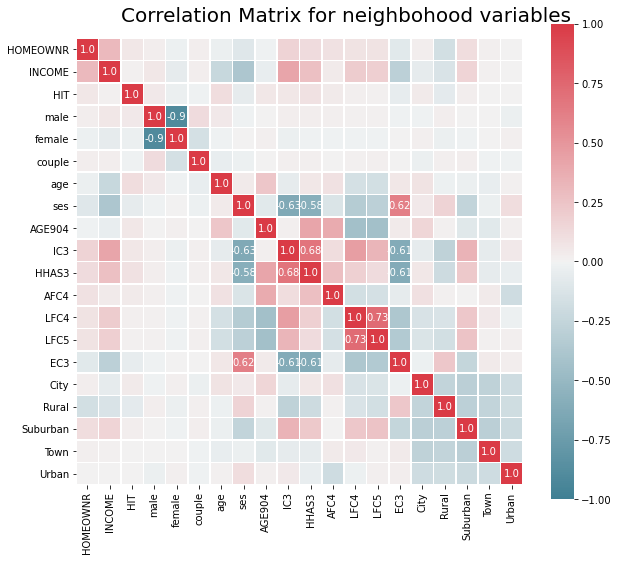

In [19]:

# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(labeled[tabs].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix for neighbohood variables", fontsize=20)

plt.show()

In [20]:
# will inspect the correlated areas and look for significance

In [21]:
clust_0 = pd.DataFrame(labeled[labeled['label_1']== 0])
clust_1 = pd.DataFrame(labeled[labeled['label_1']== 1])
clust_2 = pd.DataFrame(labeled[labeled['label_1']== 2])

In [22]:
statistics(clust_0['EC3'])

,Mean,Standard Deviation,Median,Variance
Variable,,,,
EC3,0.266111,0.124285,0.25,0.015447


In [23]:
statistics(clust_2['EC3'])

,Mean,Standard Deviation,Median,Variance
Variable,,,,
EC3,0.147582,0.080761,0.134615,0.006522


In [24]:
statistics(clust_1['EC3'])

,Mean,Standard Deviation,Median,Variance
Variable,,,,
EC3,0.360196,0.1209,0.346154,0.014617


#### Insignificant results lead to a decission to use only the selected variables from the list below

In [25]:
#will only be using pre-selected variables :

#AGE904 Average Age of Population
#IC3   Average Household Income in hundreds
#HHAS3 Percent Households w/ Interest, Rental or Dividend Income
#AFC4   Percent Adult Veterans Age 16+
#EC3 Percent Adults 25+ w/ some High School

In [26]:
clust_0 = clust_0.rename(columns={'AGE904': 'Average_Age', 'IC3': 'Avg_HH_Income', 'HHAS3':'Rental_or_Dividend_Income' ,
                        'AFC4':'Adult_Veterans','EC3':'Hood_Education_lvl'
                       })
clust_1 = clust_1.rename(columns={'AGE904': 'Average_Age', 'IC3': 'Avg_HH_Income', 'HHAS3':'Rental_or_Dividend_Income' ,
                        'AFC4':'Adult_Veterans','EC3':'Hood_Education_lvl'
                       })
clust_2 = clust_2.rename(columns={'AGE904': 'Average_Age', 'IC3': 'Avg_HH_Income', 'HHAS3':'Rental_or_Dividend_Income' ,
                        'AFC4':'Adult_Veterans','EC3':'Hood_Education_lvl'
                       })
labeled = labeled.rename(columns={'LFC4': 'Adult_Males_Employed', 'LFC5': 'Adult_Females_Employed'})
hoodie =['Average_Age','Avg_HH_Income','Rental_or_Dividend_Income','Adult_Veterans','Hood_Education_lvl']

In [27]:
# will inspect if there's any difference in distribution when it comes to age

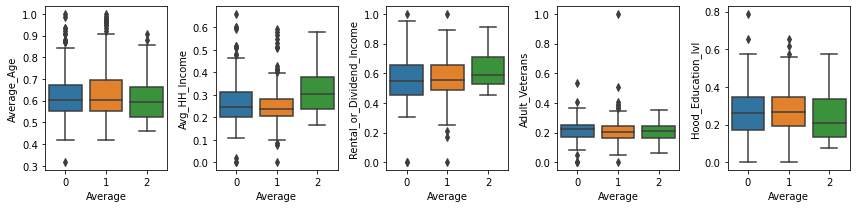

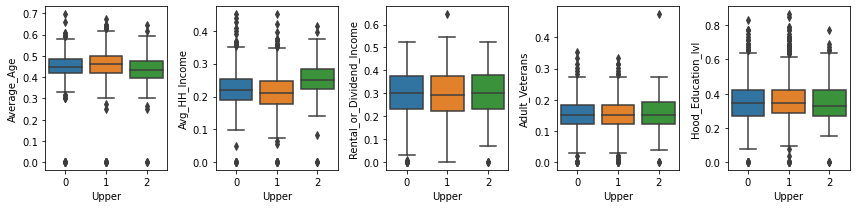

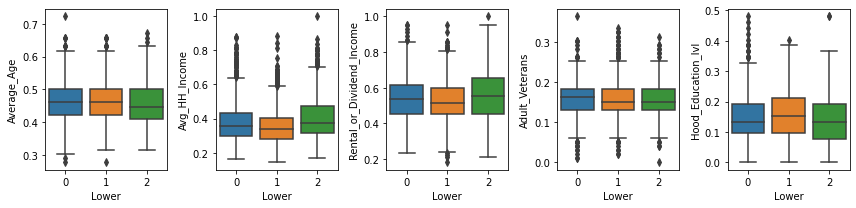

In [28]:
f, axes = plt.subplots(1, 5, figsize=(12,3))

for i in range(len(hoodie)):
    sns.boxplot(y=hoodie[i], x="label_2", data=clust_0[hoodie+["label_2"]], ax=axes[i]).set(xlabel='Average')

plt.tight_layout()


f, axes = plt.subplots(1, 5, figsize=(12,3))

for i in range(len(hoodie)):
    sns.boxplot(y=hoodie[i], x="label_2", data=clust_1[hoodie+["label_2"]], ax=axes[i]).set(xlabel='Upper')
plt.tight_layout()    
f, axes = plt.subplots(1, 5, figsize=(12,3))

for i in range(len(hoodie)):
    sns.boxplot(y=hoodie[i], x="label_2", data=clust_2[hoodie+["label_2"]], ax=axes[i]).set(xlabel='Lower')
plt.tight_layout()

In [ ]:
# as suspected the differences are based on income and age. would be great to clean the outliers, but oh well...

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


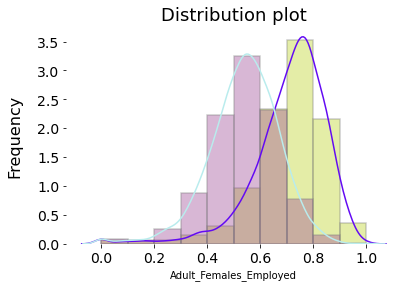

In [29]:
# Last thing i'll check
graph_histo(labeled['Adult_Males_Employed'])
graph_histo(labeled['Adult_Females_Employed'])

##### Hopefully this will help you with visualising and investigating your clusters